In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd  /content/drive/MyDrive/FaceDetection


/content/drive/MyDrive/FaceDetection


In [1]:
%pip install tensorflow ultralytics

/bin/bash: /home/dscilab/anaconda3/envs/yolov8/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install fiftyone

/bin/bash: /home/dscilab/anaconda3/envs/yolov8/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Obtaining dependency information for fiftyone from https://files.pythonhosted.org/packages/b5/c7/df60135609bdf177f484639c0129d5dfd57b4916f4e9f4f72a7ed144beb6/fiftyone-0.23.8-py3-none-any.whl.metadata
  Obtaining dependency information for aiofiles from https://files.pythonhosted.org/packages/c5/19/5af6804c4cc0fed83f47bff6e413a98a36618e7d40185cd36e69737f3b0e/aiofiles-23.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for argcomplete from https://files.pythonhosted.org/packages/db/fb/feb8456bef211621ed410909df4a3ab66d688be821dfcb1080956158d0cb/argcomplete-3.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for beautifulsoup4 from https://files.pythonhosted.org/packages/b1/fe/e8c672695b37eecc5cbf43e1d0638d88d66ba3a44c4d321c796f4e59167f/beautifulsoup4-4.12.3-py3-none-any.whl.metadata
  Obtaining dependency information for boto3 from ht

1. Get Dataset from Open Image Dataset

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import shutil
import cv2
from matplotlib import pyplot as plt

In [ ]:
import fiftyone
dataset = fiftyone.zoo.load_zoo_dataset(
              "open-images-v6",
              split="test",
              label_types=["detections"],
              classes=["Human face"],
              # max_samples=100,
          )

2. Train-Test-Valid split

In [ ]:
shutil.rmtree('RawData/images', ignore_errors=True)
shutil.rmtree('RawData/labels', ignore_errors=True)
os.mkdir('RawData/images')
os.mkdir('RawData/labels')
for dataset in ['train', 'test', 'val']:
    os.mkdir(os.path.join('RawData/images', dataset))
    os.mkdir(os.path.join('RawData/labels', dataset))

In [ ]:
np.random.seed(0)
indices = np.arange(len(imgs))
np.random.shuffle(indices)
print(indices)

In [ ]:
datadir = '/root/fiftyone/open-images-v6/validation'
imgs =  os.listdir('/root/fiftyone/open-images-v6/validation/data')
len(imgs)
train_size = int(len(imgs) * 0.7)
test_size = int(len(imgs) * 0.15)
val_size = len(imgs) - train_size - test_size
print((train_size, test_size, val_size))
for i in indices[:train_size]:
  shutil.copy(os.path.join(datadir, 'data', imgs[i]), os.path.join('RawData/images', 'train', imgs[i]))
for i in indices[train_size:train_size+test_size]:
  shutil.copy(os.path.join(datadir, 'data', imgs[i]), os.path.join('RawData/images', 'test', imgs[i]))
for i in indices[-val_size:]:
  shutil.copy(os.path.join(datadir, 'data', imgs[i]), os.path.join('RawData/images', 'val', imgs[i]))

In [ ]:
all = pd.read_csv('/root/fiftyone/open-images-v6/validation/labels/detections.csv')
train_imgs = os.listdir('RawData/images/train')
train_imgs = [i.split('.')[0] for i in train_imgs]
test_imgs = os.listdir('RawData/images/test')
test_imgs = [i.split('.')[0] for i in test_imgs]
val_imgs = os.listdir('RawData/images/val')
val_imgs = [i.split('.')[0] for i in val_imgs]
humanface_lb = all[all.LabelName=='/m/0dzct']
train_labels = humanface_lb[humanface_lb.ImageID.isin(train_imgs)]
test_labels = humanface_lb[humanface_lb.ImageID.isin(test_imgs)]
val_labels = humanface_lb[humanface_lb.ImageID.isin(val_imgs)]
len(train_labels), len(test_labels), len(val_labels)

3. Write annotation file - .txt 
YOLO form: [x_center, y_center, width, height]


In [ ]:
def write_annotation(row, settype):
  x0 = row.XMin
  x1 = row.XMax
  y0 = row.YMin
  y1 = row.YMax
  xcen = (x0 + x1)/2
  ycen = (y0 + y1)/2
  w = x1 - x0
  h = y1 - y0
  with open(os.path.join('RawData/labels', settype, row.ImageID + '.txt'), 'a') as file:
    file.write(f'0 {xcen} {ycen} {w} {h}\n')

In [ ]:
train_labels.apply(lambda row: write_annotation(row, 'train'), axis=1)
test_labels.apply(lambda row: write_annotation(row, 'test'), axis=1)
val_labels.apply(lambda row: write_annotation(row, 'val'), axis=1)

In [15]:
%pip install albumentations

/bin/bash: /home/dscilab/anaconda3/envs/yolov8/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/d3/23/70ea1667f96586fb21645a70b880703586a6133e6e3c0bcf7cf06499b594/albumentations-1.4.6-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.24.4 from https://files.pythonhosted.org/packages/98/5d/5738903efe0ecb73e51eb44feafba32bdba2081263d40c5043568ff60faf/numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.9.0 from https://files.pythonhosted.org/packages/01/f3/936e209267d6ef7510322191003885de524fc48d1b43269810cd589ceaf5/typing_extensions-4.11.0-py3-none-any.whl.metadata
  Obtaining dependency information for pydantic>=2.7.0 from https://files.pythonhosted.org/packages/ed/76/9a17032880ed27f2dbd490c77a3431cbc80f47ba81534131de3c2846e736/pydantic-2.7.1-py3-none-an

4. Data Augmentation

In [12]:
# datadir = '/root/fiftyone/open-images-v6/validation'
shutil.rmtree('Data/images', ignore_errors=True)
shutil.rmtree('Data/labels', ignore_errors=True)
os.mkdir('Data/images')
os.mkdir('Data/labels')
for dataset in ['train', 'test', 'val']:
    os.mkdir(os.path.join('Data/images', dataset))
    os.mkdir(os.path.join('Data/labels', dataset))


In [ ]:
import albumentations as alb
from matplotlib import pyplot as plt
import cv2
import os
transform = alb.Compose([
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='yolo', label_fields=['class_labels']))

for corpus in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('Raw_Data/images', corpus)):
        img_path  = os.path.join('Raw_Data/images', corpus, file)
        label_path = os.path.join('Raw_Data/labels', corpus, file.split('.')[0] + '.txt')
        img = cv2.imread(img_path)
        with open(label_path,'r') as f:
            content = f.read()
            bboxes = []
            for line in content.split('\n')[:-1]:
                bbox = line.split()[1:]
                bbox = [float(val) for val in bbox]
                bboxes += [bbox]
            if len(bboxes) == 0:
                bboxes = [[0.00001, 0.00001, 0, 0]]
        try:
            for i in range(5):
                augmented = transform(image=img, bboxes=bboxes, class_labels=[0]*len(bboxes))
                new_img = augmented['image']
                cv2.imwrite(os.path.join('Data/images', corpus, f'{file.split(".")[0]}.{i}.jpg'), new_img)
                new_bboxes = augmented['bboxes']
                with open(os.path.join('Data/labels', corpus, f'{file.split(".")[0]}.{i}.txt'), 'a') as f:
                    for bbox in new_bboxes:                                                                                                               
                        f.write(f'0 {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n')
                    if len(bboxes) == 0:
                        f.write('\n')
        except Exception as e:                                 
            print(e)

5. Training

In [1]:
from ultralytics import YOLO


In [42]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch
# Use the model
model.train(data="config.yaml", epochs=300)  # train the model


New https://pypi.org/project/ultralytics/8.2.9 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.6 🚀 Python-3.8.18 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2080, 7972MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=config.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_f

train: Scanning /home/dscilab/Documents/countface/FaceDetection/Data/labels/train... 10925 images, 0 backgrounds, 65 corrupt: 100%|██████████| 10925/10925 [00:13<00:00, 783.74it/s] 

train: WARNING ⚠️ /home/dscilab/Documents/countface/FaceDetection/Data/images/train/0787ba239b4ca568.0.jpg: ignoring corrupt image/label: could not convert string to float: '(0.51106196,'
train: WARNING ⚠️ /home/dscilab/Documents/countface/FaceDetection/Data/images/train/0787ba239b4ca568.1.jpg: ignoring corrupt image/label: could not convert string to float: '(0.48893803999999996,'
train: WARNING ⚠️ /home/dscilab/Documents/countface/FaceDetection/Data/images/train/0787ba239b4ca568.2.jpg: ignoring corrupt image/label: could not convert string to float: '(0.48893803999999996,'
train: WARNING ⚠️ /home/dscilab/Documents/countface/FaceDetection/Data/images/train/0787ba239b4ca568.3.jpg: ignoring corrupt image/label: could not convert string to float: '(0.51106196,'
train: WARNING ⚠️ /home/dscilab/Documents/countface/FaceDetection/Data/images/train/0787ba239b4ca568.4.jpg: ignoring corrupt image/label: could not convert string to float: '(0.48893803999999996,'
train: WARNING ⚠️ /home/dscilab/D

train: New cache created: /home/dscilab/Documents/countface/FaceDetection/Data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/dscilab/Documents/countface/FaceDetection/Data/labels/val... 2350 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2350/2350 [00:00<00:00, 2504.10it/s]


val: New cache created: /home/dscilab/Documents/countface/FaceDetection/Data/labels/val.cache
Plotting labels to runs/detect/train14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train14
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.32G       3.23      3.764      3.898         29        640: 100%|██████████| 679/679 [01:11<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:09<00:00,  7.72it/s]


                   all       2350       4625      0.197      0.179      0.103     0.0423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.26G      2.287      2.372      2.705         34        640: 100%|██████████| 679/679 [01:04<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.39it/s]


                   all       2350       4625      0.531      0.363      0.387       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.29G      1.804      1.834      2.135         63        640: 100%|██████████| 679/679 [01:04<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.36it/s]


                   all       2350       4625      0.605       0.47      0.496      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.26G      1.631      1.642      1.915         50        640: 100%|██████████| 679/679 [01:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.63it/s]


                   all       2350       4625      0.691       0.49      0.551      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.25G      1.529      1.503      1.818         33        640: 100%|██████████| 679/679 [01:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.77it/s]


                   all       2350       4625      0.678      0.508      0.569      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.27G      1.462      1.401       1.74         37        640: 100%|██████████| 679/679 [01:06<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.61it/s]


                   all       2350       4625      0.706      0.579      0.623       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.25G      1.418       1.34      1.698         39        640: 100%|██████████| 679/679 [01:02<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.51it/s]


                   all       2350       4625       0.74      0.556      0.635      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.24G      1.373      1.288      1.653         43        640: 100%|██████████| 679/679 [01:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.44it/s]


                   all       2350       4625      0.751      0.553      0.629      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.25G      1.344      1.238      1.625         57        640: 100%|██████████| 679/679 [01:02<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.52it/s]


                   all       2350       4625      0.748      0.582      0.644      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.25G      1.325      1.206      1.607         34        640: 100%|██████████| 679/679 [01:07<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.49it/s]


                   all       2350       4625      0.732      0.618      0.663      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.25G      1.305      1.175      1.586         27        640: 100%|██████████| 679/679 [01:07<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.62it/s]


                   all       2350       4625      0.728      0.595      0.653       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.26G      1.283      1.149      1.563         28        640: 100%|██████████| 679/679 [01:07<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.56it/s]


                   all       2350       4625      0.737      0.594      0.662      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.28G      1.263      1.113      1.548         32        640: 100%|██████████| 679/679 [01:07<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.58it/s]


                   all       2350       4625      0.775      0.628      0.686      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.27G      1.248        1.1      1.531         40        640: 100%|██████████| 679/679 [01:07<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.52it/s]


                   all       2350       4625      0.745      0.633      0.686      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.27G      1.248      1.093      1.528         27        640: 100%|██████████| 679/679 [01:07<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.57it/s]


                   all       2350       4625      0.746      0.622      0.685      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.28G      1.221      1.059      1.509         36        640: 100%|██████████| 679/679 [01:07<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.65it/s]


                   all       2350       4625      0.747      0.622      0.685       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.25G      1.215      1.052      1.503         39        640: 100%|██████████| 679/679 [01:07<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.55it/s]


                   all       2350       4625      0.764      0.633      0.692       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.28G      1.204      1.036      1.495         53        640: 100%|██████████| 679/679 [01:06<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.67it/s]

                   all       2350       4625      0.761      0.647      0.711      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.27G      1.193      1.025       1.48         29        640: 100%|██████████| 679/679 [01:06<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.66it/s]


                   all       2350       4625      0.748      0.655      0.704      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.28G      1.186      1.001      1.469         38        640: 100%|██████████| 679/679 [01:07<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.67it/s]


                   all       2350       4625      0.751      0.641      0.703      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.25G      1.176     0.9914      1.468         38        640: 100%|██████████| 679/679 [01:07<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.50it/s]


                   all       2350       4625      0.792      0.646      0.709       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.28G      1.176     0.9919      1.463         34        640: 100%|██████████| 679/679 [01:06<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.70it/s]


                   all       2350       4625      0.769      0.644      0.701      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.28G      1.161     0.9654      1.456         44        640: 100%|██████████| 679/679 [01:07<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.70it/s]


                   all       2350       4625      0.768       0.66      0.717      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.28G       1.16     0.9718       1.44         30        640: 100%|██████████| 679/679 [01:06<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.57it/s]


                   all       2350       4625       0.77      0.652       0.71      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.25G      1.141     0.9428      1.429         36        640: 100%|██████████| 679/679 [01:06<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.68it/s]


                   all       2350       4625      0.774      0.632      0.699      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.18G      1.134     0.9298      1.428         68        640: 100%|██████████| 679/679 [01:06<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.66it/s]


                   all       2350       4625      0.753      0.661      0.707      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.25G      1.126     0.9297      1.422         40        640: 100%|██████████| 679/679 [01:06<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.69it/s]


                   all       2350       4625      0.784      0.632      0.702      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.27G      1.117     0.9174      1.416         34        640: 100%|██████████| 679/679 [01:06<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.21it/s]

                   all       2350       4625      0.795       0.65       0.71      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.23G      1.125     0.9157      1.414         30        640: 100%|██████████| 679/679 [01:03<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.24it/s]


                   all       2350       4625      0.767      0.657      0.715       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.28G      1.114     0.9091      1.406         41        640: 100%|██████████| 679/679 [01:03<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.23it/s]


                   all       2350       4625      0.788      0.669      0.717      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.27G      1.101     0.8889      1.391         43        640: 100%|██████████| 679/679 [01:03<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.23it/s]

                   all       2350       4625      0.783      0.641      0.701      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.27G      1.095     0.8751      1.387         29        640: 100%|██████████| 679/679 [01:03<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.21it/s]

                   all       2350       4625      0.785      0.665      0.722      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.28G      1.099     0.8745      1.385         40        640: 100%|██████████| 679/679 [01:03<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.09it/s]


                   all       2350       4625      0.815      0.645      0.712      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.23G      1.091     0.8832      1.382         44        640: 100%|██████████| 679/679 [01:03<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.21it/s]


                   all       2350       4625      0.803      0.646       0.71      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.25G      1.085      0.863      1.381         21        640: 100%|██████████| 679/679 [01:03<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.13it/s]

                   all       2350       4625      0.782       0.67      0.718      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.25G      1.082     0.8527      1.373         49        640: 100%|██████████| 679/679 [01:03<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.27it/s]


                   all       2350       4625      0.787      0.651      0.712      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.27G      1.075     0.8561      1.366         27        640: 100%|██████████| 679/679 [01:03<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.13it/s]


                   all       2350       4625      0.799      0.654       0.71      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.27G      1.072     0.8415      1.368         29        640: 100%|██████████| 679/679 [01:04<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.25it/s]

                   all       2350       4625        0.8      0.651      0.709      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.27G      1.073     0.8353      1.369         29        640: 100%|██████████| 679/679 [01:03<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.15it/s]


                   all       2350       4625      0.797      0.659      0.715       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.27G      1.055     0.8318      1.352         31        640: 100%|██████████| 679/679 [01:03<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.28it/s]

                   all       2350       4625       0.77       0.67      0.722      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.22G      1.056     0.8294      1.348         31        640: 100%|██████████| 679/679 [01:02<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.63it/s]


                   all       2350       4625      0.761      0.672      0.712      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.27G      1.058     0.8244      1.349         36        640: 100%|██████████| 679/679 [01:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.67it/s]


                   all       2350       4625      0.792      0.657      0.715      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.25G      1.054     0.8134      1.344         35        640: 100%|██████████| 679/679 [01:01<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.72it/s]


                   all       2350       4625       0.79       0.67       0.72      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.28G      1.046     0.8127      1.335         50        640: 100%|██████████| 679/679 [01:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.76it/s]


                   all       2350       4625      0.799      0.654      0.716      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.28G      1.039     0.8055       1.33         67        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.62it/s]


                   all       2350       4625      0.797      0.667      0.719      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.27G      1.041     0.7964      1.327         30        640: 100%|██████████| 679/679 [01:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.56it/s]


                   all       2350       4625      0.792      0.662      0.711      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.25G      1.041      0.792      1.324         25        640: 100%|██████████| 679/679 [01:00<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.68it/s]


                   all       2350       4625      0.794      0.672      0.718      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.28G      1.033     0.7877      1.322         36        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.71it/s]


                   all       2350       4625      0.805      0.667      0.719      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.25G      1.031     0.7948      1.324         38        640: 100%|██████████| 679/679 [01:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.59it/s]


                   all       2350       4625      0.804      0.661      0.716      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.28G      1.025     0.7764      1.313         29        640: 100%|██████████| 679/679 [01:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.73it/s]


                   all       2350       4625        0.8       0.66      0.712      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.27G      1.018     0.7747       1.31         37        640: 100%|██████████| 679/679 [01:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.72it/s]


                   all       2350       4625      0.797      0.666      0.715      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.25G      1.023     0.7862      1.315         33        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.69it/s]


                   all       2350       4625      0.796       0.67      0.721      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.22G      1.009      0.765      1.302         51        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.64it/s]


                   all       2350       4625      0.791      0.674      0.717      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.25G      1.014     0.7643      1.303         35        640: 100%|██████████| 679/679 [01:01<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.75it/s]


                   all       2350       4625      0.794      0.665      0.711      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.28G      1.007     0.7584        1.3         39        640: 100%|██████████| 679/679 [01:00<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.68it/s]

                   all       2350       4625      0.792      0.674      0.717      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.23G      1.004     0.7541      1.295         39        640: 100%|██████████| 679/679 [01:00<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.71it/s]

                   all       2350       4625      0.806      0.663      0.718      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.25G      1.002     0.7502      1.292         25        640: 100%|██████████| 679/679 [01:00<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.67it/s]

                   all       2350       4625      0.793      0.671      0.718      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.16G     0.9935      0.739       1.28         45        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.76it/s]

                   all       2350       4625      0.802       0.67      0.721      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.25G     0.9938     0.7424      1.289         46        640: 100%|██████████| 679/679 [01:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.73it/s]

                   all       2350       4625      0.804      0.669      0.716      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.25G     0.9922     0.7356      1.284         40        640: 100%|██████████| 679/679 [01:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.68it/s]

                   all       2350       4625      0.801      0.667      0.717      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.24G     0.9849     0.7326      1.274         40        640: 100%|██████████| 679/679 [01:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.72it/s]

                   all       2350       4625      0.796      0.677      0.718      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.25G      0.989     0.7286      1.279         30        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.88it/s]


                   all       2350       4625      0.811      0.669      0.723      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.27G     0.9817     0.7247      1.273         44        640: 100%|██████████| 679/679 [01:03<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.56it/s]

                   all       2350       4625      0.813      0.664      0.722      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.25G     0.9757     0.7226       1.27         41        640: 100%|██████████| 679/679 [01:05<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.01it/s]


                   all       2350       4625      0.818      0.656      0.722      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.25G     0.9692     0.7101      1.265         46        640: 100%|██████████| 679/679 [01:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.81it/s]


                   all       2350       4625       0.79      0.673      0.722      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.23G     0.9672     0.7029      1.258         44        640: 100%|██████████| 679/679 [01:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.75it/s]


                   all       2350       4625      0.798      0.671      0.721      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.27G      0.969     0.7089      1.266         26        640: 100%|██████████| 679/679 [01:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.93it/s]

                   all       2350       4625      0.811      0.662      0.723      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.27G     0.9692     0.7103      1.262         43        640: 100%|██████████| 679/679 [01:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.91it/s]


                   all       2350       4625      0.802      0.668      0.723      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.25G     0.9634     0.7034      1.256         22        640: 100%|██████████| 679/679 [01:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.00it/s]


                   all       2350       4625       0.82      0.659      0.724      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.27G     0.9595     0.6928      1.253         49        640: 100%|██████████| 679/679 [01:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.53it/s]


                   all       2350       4625      0.816      0.663      0.723      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.27G     0.9601     0.6993       1.25         34        640: 100%|██████████| 679/679 [01:03<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.73it/s]

                   all       2350       4625      0.805      0.673      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.25G     0.9502     0.6863      1.247         36        640: 100%|██████████| 679/679 [01:06<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.95it/s]

                   all       2350       4625      0.812       0.67      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.25G     0.9478     0.6878      1.244         43        640: 100%|██████████| 679/679 [01:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.90it/s]

                   all       2350       4625      0.812       0.67      0.725      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.27G     0.9463     0.6784      1.242         31        640: 100%|██████████| 679/679 [01:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.76it/s]

                   all       2350       4625      0.812      0.666      0.724      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.23G     0.9448     0.6791      1.242         25        640: 100%|██████████| 679/679 [01:05<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.86it/s]

                   all       2350       4625      0.807       0.67      0.726      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.25G     0.9449     0.6779      1.237         60        640: 100%|██████████| 679/679 [01:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.99it/s]

                   all       2350       4625      0.799      0.674      0.725      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.25G     0.9425     0.6778      1.232         52        640: 100%|██████████| 679/679 [01:02<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.62it/s]

                   all       2350       4625      0.812      0.662      0.725        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.17G     0.9417     0.6759      1.236         44        640: 100%|██████████| 679/679 [01:05<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.00it/s]


                   all       2350       4625      0.809      0.667      0.724      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.27G     0.9328     0.6665      1.229         34        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.92it/s]


                   all       2350       4625      0.806      0.671      0.724      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.25G     0.9329     0.6659      1.226         27        640: 100%|██████████| 679/679 [01:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.95it/s]


                   all       2350       4625      0.812      0.665      0.723        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.25G     0.9298     0.6663      1.227         39        640: 100%|██████████| 679/679 [01:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.89it/s]

                   all       2350       4625      0.812      0.666      0.725      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.27G      0.921     0.6573      1.222         41        640: 100%|██████████| 679/679 [01:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.94it/s]

                   all       2350       4625       0.81      0.667      0.723      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.25G     0.9257     0.6541      1.218         32        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.92it/s]

                   all       2350       4625      0.815      0.664      0.723      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.23G     0.9231      0.658      1.216         36        640: 100%|██████████| 679/679 [01:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.80it/s]


                   all       2350       4625      0.805       0.67      0.723        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.18G     0.9199     0.6524      1.214         49        640: 100%|██████████| 679/679 [01:03<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.66it/s]

                   all       2350       4625      0.811      0.669      0.723      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.27G     0.9137     0.6463      1.214         37        640: 100%|██████████| 679/679 [01:06<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.88it/s]

                   all       2350       4625      0.806      0.672      0.723      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.17G     0.9104     0.6464      1.206         42        640: 100%|██████████| 679/679 [01:04<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.77it/s]

                   all       2350       4625      0.803      0.677      0.724        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.25G      0.914     0.6463      1.211         37        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.96it/s]

                   all       2350       4625      0.805      0.674      0.725      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.25G     0.9078     0.6382      1.204         44        640: 100%|██████████| 679/679 [01:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.87it/s]

                   all       2350       4625      0.791      0.685      0.725      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.25G     0.9084     0.6407      1.203         49        640: 100%|██████████| 679/679 [01:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.05it/s]

                   all       2350       4625      0.791      0.686      0.725      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.25G     0.9032     0.6352      1.198         43        640: 100%|██████████| 679/679 [01:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.91it/s]

                   all       2350       4625      0.793      0.684      0.725      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.25G     0.9003     0.6323      1.196         22        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.93it/s]

                   all       2350       4625      0.794      0.683      0.725      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.23G      0.905     0.6337      1.197         37        640: 100%|██████████| 679/679 [01:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.00it/s]

                   all       2350       4625      0.793      0.683      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.25G     0.8984      0.632      1.199         35        640: 100%|██████████| 679/679 [01:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.68it/s]


                   all       2350       4625      0.796      0.681      0.726        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.27G     0.9061     0.6377      1.199         27        640: 100%|██████████| 679/679 [01:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.97it/s]

                   all       2350       4625      0.796      0.679      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.25G     0.8931     0.6189      1.189         50        640: 100%|██████████| 679/679 [01:05<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.90it/s]

                   all       2350       4625      0.802      0.677      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.25G     0.8957     0.6209      1.189         34        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.90it/s]

                   all       2350       4625      0.802      0.677      0.727        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.27G     0.8957     0.6225      1.189         41        640: 100%|██████████| 679/679 [01:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.95it/s]

                   all       2350       4625      0.801      0.677      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.25G     0.8939     0.6199      1.189         53        640: 100%|██████████| 679/679 [01:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.84it/s]

                   all       2350       4625      0.802      0.677      0.727        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.36G     0.8932     0.6162      1.187         45        640: 100%|██████████| 679/679 [01:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.97it/s]

                   all       2350       4625      0.804      0.672      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.27G     0.8904      0.616      1.183         38        640: 100%|██████████| 679/679 [01:04<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.30it/s]

                   all       2350       4625      0.811      0.669      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.28G     0.8796      0.608      1.175         40        640: 100%|██████████| 679/679 [01:03<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.71it/s]

                   all       2350       4625      0.815      0.668      0.727        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.27G     0.8843     0.6082      1.178         27        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.94it/s]

                   all       2350       4625      0.816      0.667      0.727        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.25G     0.8762     0.6076      1.177         35        640: 100%|██████████| 679/679 [01:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.94it/s]

                   all       2350       4625      0.817      0.667      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.27G     0.8765      0.605      1.176         34        640: 100%|██████████| 679/679 [01:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.94it/s]

                   all       2350       4625      0.819      0.666      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.25G     0.8716     0.6027      1.167         61        640: 100%|██████████| 679/679 [01:03<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.80it/s]

                   all       2350       4625       0.82      0.666      0.726      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.28G     0.8683     0.5963       1.17         40        640: 100%|██████████| 679/679 [01:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.01it/s]

                   all       2350       4625      0.819      0.666      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.23G     0.8773      0.606      1.162         41        640: 100%|██████████| 679/679 [01:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.95it/s]

                   all       2350       4625      0.817      0.666      0.726      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.25G     0.8672     0.5934      1.163         39        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.01it/s]

                   all       2350       4625      0.817      0.666      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.17G     0.8677     0.5928      1.167         41        640: 100%|██████████| 679/679 [01:02<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.69it/s]

                   all       2350       4625       0.82      0.663      0.726      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.27G     0.8638     0.5912      1.163         38        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.03it/s]

                   all       2350       4625      0.818      0.665      0.725      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.23G       0.86     0.5908      1.159         47        640: 100%|██████████| 679/679 [01:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.58it/s]

                   all       2350       4625      0.819      0.663      0.726      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.25G       0.86      0.587      1.155         46        640: 100%|██████████| 679/679 [01:03<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.04it/s]

                   all       2350       4625      0.818      0.663      0.726      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.27G     0.8609     0.5897      1.161         35        640: 100%|██████████| 679/679 [01:02<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.61it/s]

                   all       2350       4625      0.815      0.665      0.725      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.25G     0.8521     0.5795       1.15         31        640: 100%|██████████| 679/679 [01:01<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.55it/s]

                   all       2350       4625      0.815      0.666      0.725      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.25G     0.8559      0.584      1.151         52        640: 100%|██████████| 679/679 [01:01<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.69it/s]


                   all       2350       4625      0.815      0.664      0.725      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.25G     0.8519     0.5858      1.155         35        640: 100%|██████████| 679/679 [01:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.66it/s]

                   all       2350       4625      0.818      0.662      0.725      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      2.28G     0.8475     0.5796      1.147         43        640: 100%|██████████| 679/679 [01:01<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.64it/s]

                   all       2350       4625      0.817      0.663      0.725      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      2.27G     0.8487     0.5816      1.143         48        640: 100%|██████████| 679/679 [01:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.73it/s]

                   all       2350       4625      0.818      0.662      0.724      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      2.25G     0.8483     0.5796      1.148         39        640: 100%|██████████| 679/679 [01:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.42it/s]

                   all       2350       4625      0.817      0.662      0.724      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.25G      0.845     0.5721      1.138         32        640: 100%|██████████| 679/679 [01:01<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.67it/s]

                   all       2350       4625      0.817      0.662      0.724        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      2.25G      0.845     0.5746       1.14         36        640: 100%|██████████| 679/679 [01:01<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.70it/s]

                   all       2350       4625      0.817      0.661      0.724      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      2.23G     0.8451     0.5738      1.141         30        640: 100%|██████████| 679/679 [01:01<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.74it/s]

                   all       2350       4625      0.819      0.661      0.724      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      2.28G     0.8389     0.5739       1.14         51        640: 100%|██████████| 679/679 [01:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.67it/s]

                   all       2350       4625      0.817      0.662      0.724      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.39G     0.8383     0.5691      1.138         38        640: 100%|██████████| 679/679 [01:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.56it/s]

                   all       2350       4625      0.815      0.665      0.724      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.27G     0.8389     0.5637      1.135         24        640: 100%|██████████| 679/679 [01:00<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.73it/s]

                   all       2350       4625      0.818      0.664      0.723      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.27G     0.8291     0.5596      1.132         43        640: 100%|██████████| 679/679 [01:01<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.69it/s]

                   all       2350       4625      0.816      0.665      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.23G     0.8285     0.5632      1.124         30        640: 100%|██████████| 679/679 [01:01<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.67it/s]

                   all       2350       4625      0.815      0.665      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.27G     0.8287     0.5603      1.131         36        640: 100%|██████████| 679/679 [01:01<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.55it/s]

                   all       2350       4625      0.816      0.663      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.23G     0.8255     0.5565      1.128         37        640: 100%|██████████| 679/679 [01:05<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.90it/s]

                   all       2350       4625      0.814      0.663      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.23G     0.8225     0.5535      1.125         34        640: 100%|██████████| 679/679 [01:02<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.65it/s]

                   all       2350       4625      0.814      0.663      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.25G     0.8339     0.5552      1.126         72        640: 100%|██████████| 679/679 [01:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.97it/s]

                   all       2350       4625      0.812      0.666      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.25G     0.8226     0.5538      1.124         53        640: 100%|██████████| 679/679 [01:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.62it/s]

                   all       2350       4625      0.811      0.667      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.28G     0.8189     0.5498       1.12         48        640: 100%|██████████| 679/679 [01:02<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.67it/s]

                   all       2350       4625      0.812      0.667      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.27G     0.8258     0.5534      1.125         39        640: 100%|██████████| 679/679 [01:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.93it/s]

                   all       2350       4625      0.811      0.668      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.25G     0.8172     0.5426      1.119         54        640: 100%|██████████| 679/679 [01:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.86it/s]

                   all       2350       4625      0.809      0.669      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.25G     0.8125      0.547      1.114         41        640: 100%|██████████| 679/679 [01:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.05it/s]

                   all       2350       4625      0.806       0.67      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.25G     0.8103     0.5413       1.11         39        640: 100%|██████████| 679/679 [01:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.99it/s]

                   all       2350       4625      0.806       0.67      0.723      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.27G     0.8115     0.5428      1.114         41        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.83it/s]

                   all       2350       4625      0.812      0.666      0.723      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.25G     0.8169     0.5434      1.115         71        640: 100%|██████████| 679/679 [01:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.02it/s]

                   all       2350       4625       0.81      0.667      0.723      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.25G     0.8114     0.5443      1.111         35        640: 100%|██████████| 679/679 [01:06<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.60it/s]

                   all       2350       4625      0.812      0.664      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.25G      0.805     0.5385      1.108         25        640: 100%|██████████| 679/679 [01:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.07it/s]

                   all       2350       4625      0.811      0.667      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.27G     0.8111       0.54      1.111         36        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.73it/s]

                   all       2350       4625      0.811      0.667      0.724      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.25G     0.8021     0.5339      1.107         36        640: 100%|██████████| 679/679 [01:05<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.03it/s]

                   all       2350       4625      0.807       0.67      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.25G     0.8066     0.5363      1.107         42        640: 100%|██████████| 679/679 [01:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.94it/s]

                   all       2350       4625      0.807      0.668      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.25G     0.8041     0.5358      1.104         65        640: 100%|██████████| 679/679 [01:04<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.50it/s]

                   all       2350       4625      0.812      0.666      0.725      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.25G     0.7962     0.5279      1.098         32        640: 100%|██████████| 679/679 [01:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.32it/s]

                   all       2350       4625      0.816      0.663      0.725      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.25G     0.7896     0.5278      1.097         33        640: 100%|██████████| 679/679 [01:01<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.74it/s]

                   all       2350       4625      0.815      0.664      0.724      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.25G     0.7942     0.5277      1.095         44        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.73it/s]

                   all       2350       4625      0.816      0.663      0.725      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      2.25G     0.7981      0.527        1.1         30        640: 100%|██████████| 679/679 [01:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.87it/s]

                   all       2350       4625      0.814      0.664      0.725      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.25G     0.7953     0.5267      1.099         33        640: 100%|██████████| 679/679 [01:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.80it/s]

                   all       2350       4625      0.815      0.664      0.725      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.25G     0.8048     0.5335      1.093         65        640:  11%|█         | 72/679 [00:07<01:01,  9.85it/s]


KeyboardInterrupt: 

currently train 14

In [2]:
model = YOLO('runs/detect/train14/weights/last.pt')
model.train(resume=True)

New https://pypi.org/project/ultralytics/8.2.11 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.6 🚀 Python-3.8.18 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2080, 7972MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/train14/weights/last.pt, data=config.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=runs/detect/train14/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=No

train: Scanning /home/dscilab/Documents/countface/FaceDetection/Data/labels/train.cache... 10925 images, 0 backgrounds, 65 corrupt: 100%|██████████| 10925/10925 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/dscilab/Documents/countface/FaceDetection/Data/images/train/0787ba239b4ca568.0.jpg: ignoring corrupt image/label: could not convert string to float: '(0.51106196,'
train: WARNING ⚠️ /home/dscilab/Documents/countface/FaceDetection/Data/images/train/0787ba239b4ca568.1.jpg: ignoring corrupt image/label: could not convert string to float: '(0.48893803999999996,'
train: WARNING ⚠️ /home/dscilab/Documents/countface/FaceDetection/Data/images/train/0787ba239b4ca568.2.jpg: ignoring corrupt image/label: could not convert string to float: '(0.48893803999999996,'
train: WARNING ⚠️ /home/dscilab/Documents/countface/FaceDetection/Data/images/train/0787ba239b4ca568.3.jpg: ignoring corrupt image/label: could not convert string to float: '(0.51106196,'
train: WARNING ⚠️ /home/dscilab/Documents/countface/FaceDetection/Data/images/train/0787ba239b4ca568.4.jpg: ignoring corrupt image/label: could not convert string to float: '(0.48893803999999996,'
train: WARNING ⚠️ /home/dscilab/D

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/dscilab/Documents/countface/FaceDetection/Data/labels/val.cache... 2350 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2350/2350 [00:00<?, ?it/s]


Plotting labels to runs/detect/train14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training runs/detect/train14/weights/last.pt from epoch 152 to 300 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train14
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.29G     0.8072     0.5345      1.121         29        640: 100%|██████████| 679/679 [01:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:08<00:00,  8.59it/s]

                   all       2350       4625      0.815      0.664      0.725      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.24G     0.8195     0.5478      1.128         34        640: 100%|██████████| 679/679 [01:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.99it/s]

                   all       2350       4625      0.816      0.663      0.724      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      2.28G     0.8151     0.5418      1.124         63        640: 100%|██████████| 679/679 [01:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.91it/s]

                   all       2350       4625      0.816      0.663      0.724      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      2.24G     0.8183     0.5463      1.121         50        640: 100%|██████████| 679/679 [01:06<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.88it/s]

                   all       2350       4625      0.817      0.663      0.724      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      2.24G     0.8132       0.54      1.126         33        640: 100%|██████████| 679/679 [01:06<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.92it/s]

                   all       2350       4625      0.819      0.663      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.28G     0.8158     0.5423      1.123         37        640: 100%|██████████| 679/679 [01:02<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.77it/s]

                   all       2350       4625      0.817      0.663      0.724      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      2.26G     0.8071     0.5403      1.116         39        640: 100%|██████████| 679/679 [01:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.69it/s]

                   all       2350       4625      0.817      0.663      0.723      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      2.24G     0.8158     0.5474      1.121         43        640: 100%|██████████| 679/679 [01:01<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.65it/s]

                   all       2350       4625      0.816      0.664      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.26G     0.8078     0.5419       1.12         57        640: 100%|██████████| 679/679 [01:01<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.82it/s]

                   all       2350       4625      0.819      0.663      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.26G     0.8109     0.5445      1.114         34        640: 100%|██████████| 679/679 [01:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.69it/s]

                   all       2350       4625      0.816      0.664      0.724      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      2.24G     0.8129      0.543       1.12         27        640: 100%|██████████| 679/679 [01:01<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.29it/s]

                   all       2350       4625      0.814      0.664      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      2.26G     0.8069     0.5417      1.114         28        640: 100%|██████████| 679/679 [01:02<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.83it/s]

                   all       2350       4625      0.813      0.664      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.28G     0.7996     0.5331      1.108         32        640: 100%|██████████| 679/679 [01:01<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.67it/s]

                   all       2350       4625      0.814      0.664      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.28G     0.8022     0.5324      1.104         40        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.06it/s]

                   all       2350       4625      0.814      0.664      0.724      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.28G     0.8039     0.5371      1.109         27        640: 100%|██████████| 679/679 [01:05<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.93it/s]

                   all       2350       4625      0.814      0.663      0.724      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      2.28G     0.7987     0.5311       1.11         36        640: 100%|██████████| 679/679 [01:06<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.89it/s]

                   all       2350       4625      0.814      0.663      0.724      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.24G     0.7976     0.5311      1.105         39        640: 100%|██████████| 679/679 [01:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.09it/s]

                   all       2350       4625      0.814      0.662      0.724      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.29G     0.7951     0.5312      1.101         53        640: 100%|██████████| 679/679 [01:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.99it/s]

                   all       2350       4625      0.814      0.661      0.724      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      2.27G     0.7971     0.5291      1.101         29        640: 100%|██████████| 679/679 [01:06<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.00it/s]

                   all       2350       4625      0.815      0.662      0.724      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.29G     0.7934     0.5292      1.098         38        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.99it/s]

                   all       2350       4625      0.816      0.661      0.724      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.26G     0.7902      0.523      1.099         38        640: 100%|██████████| 679/679 [01:05<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.96it/s]

                   all       2350       4625      0.815      0.661      0.724      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.29G      0.794     0.5289      1.095         34        640: 100%|██████████| 679/679 [01:03<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.84it/s]

                   all       2350       4625      0.814      0.661      0.724      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.29G     0.7864     0.5192        1.1         44        640: 100%|██████████| 679/679 [01:01<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.86it/s]

                   all       2350       4625      0.813      0.662      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.29G      0.792     0.5245      1.096         30        640: 100%|██████████| 679/679 [01:00<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.74it/s]

                   all       2350       4625       0.81      0.665      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.26G     0.7825     0.5162      1.093         36        640: 100%|██████████| 679/679 [01:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.71it/s]

                   all       2350       4625      0.811      0.664      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.19G     0.7819     0.5152      1.091         68        640: 100%|██████████| 679/679 [01:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.78it/s]

                   all       2350       4625      0.813      0.664      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.24G     0.7774     0.5134      1.087         40        640: 100%|██████████| 679/679 [01:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.79it/s]

                   all       2350       4625      0.811      0.664      0.723      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.28G     0.7741     0.5127      1.089         34        640: 100%|██████████| 679/679 [01:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.67it/s]

                   all       2350       4625       0.81      0.664      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.24G     0.7793     0.5121       1.09         30        640: 100%|██████████| 679/679 [01:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.79it/s]

                   all       2350       4625      0.812      0.662      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.28G     0.7744     0.5098      1.089         41        640: 100%|██████████| 679/679 [01:01<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.80it/s]

                   all       2350       4625      0.812      0.662      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      2.28G     0.7728     0.5049      1.082         43        640: 100%|██████████| 679/679 [01:01<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.56it/s]

                   all       2350       4625      0.816      0.659      0.723      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      2.28G     0.7663     0.5029      1.081         29        640: 100%|██████████| 679/679 [01:01<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.75it/s]

                   all       2350       4625      0.816      0.659      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      2.28G     0.7724     0.5045      1.086         40        640: 100%|██████████| 679/679 [01:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.86it/s]

                   all       2350       4625      0.816       0.66      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      2.24G     0.7673     0.5023      1.083         44        640: 100%|██████████| 679/679 [01:00<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.76it/s]

                   all       2350       4625      0.816       0.66      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.26G      0.769     0.5028      1.081         21        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.71it/s]

                   all       2350       4625      0.816       0.66      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      2.26G     0.7684      0.505       1.08         49        640: 100%|██████████| 679/679 [01:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.80it/s]

                   all       2350       4625      0.816       0.66      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      2.28G     0.7621     0.5008      1.075         27        640: 100%|██████████| 679/679 [01:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.79it/s]

                   all       2350       4625      0.815       0.66      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.28G     0.7593     0.4989      1.077         29        640: 100%|██████████| 679/679 [01:01<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.81it/s]

                   all       2350       4625      0.813      0.661      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      2.29G     0.7559     0.4939      1.076         29        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.73it/s]

                   all       2350       4625      0.813      0.662      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      2.28G      0.753     0.4938       1.07         31        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.88it/s]

                   all       2350       4625      0.816      0.661      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.23G     0.7531     0.4924      1.072         31        640: 100%|██████████| 679/679 [01:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.83it/s]

                   all       2350       4625      0.817      0.661      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.26G     0.7577     0.4915      1.075         36        640: 100%|██████████| 679/679 [01:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.78it/s]

                   all       2350       4625      0.817       0.66      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.24G     0.7522     0.4919      1.071         35        640: 100%|██████████| 679/679 [01:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.81it/s]

                   all       2350       4625      0.819      0.659      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      2.29G     0.7492     0.4913      1.071         50        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.77it/s]

                   all       2350       4625      0.818       0.66      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.29G     0.7468     0.4874      1.065         67        640: 100%|██████████| 679/679 [01:03<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.92it/s]

                   all       2350       4625      0.817      0.661      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.28G     0.7471     0.4842      1.063         30        640: 100%|██████████| 679/679 [01:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.97it/s]

                   all       2350       4625      0.817      0.661      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      2.26G     0.7519     0.4844      1.068         25        640: 100%|██████████| 679/679 [01:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.88it/s]

                   all       2350       4625      0.817      0.661      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      2.29G     0.7461     0.4812      1.065         36        640: 100%|██████████| 679/679 [01:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.94it/s]

                   all       2350       4625      0.816      0.661      0.722        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.26G     0.7462      0.488      1.065         38        640: 100%|██████████| 679/679 [01:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.99it/s]

                   all       2350       4625      0.815      0.662      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      2.29G     0.7407     0.4783      1.062         29        640: 100%|██████████| 679/679 [01:05<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.96it/s]

                   all       2350       4625      0.814      0.662      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      2.28G     0.7385     0.4786      1.061         37        640: 100%|██████████| 679/679 [01:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.98it/s]

                   all       2350       4625      0.814      0.663      0.721        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      2.24G     0.7427     0.4844      1.063         33        640: 100%|██████████| 679/679 [01:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.91it/s]

                   all       2350       4625      0.813      0.662      0.722        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      2.23G     0.7354     0.4743      1.058         51        640: 100%|██████████| 679/679 [01:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.99it/s]

                   all       2350       4625      0.813      0.663      0.721        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      2.24G     0.7378       0.48      1.055         35        640: 100%|██████████| 679/679 [01:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.04it/s]

                   all       2350       4625      0.811      0.663      0.721      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      2.29G     0.7315     0.4734      1.055         39        640: 100%|██████████| 679/679 [01:05<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.86it/s]

                   all       2350       4625       0.81      0.664      0.721        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      2.24G     0.7321     0.4771      1.058         39        640: 100%|██████████| 679/679 [01:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.83it/s]

                   all       2350       4625       0.81      0.663      0.721        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      2.26G      0.731     0.4739      1.055         25        640: 100%|██████████| 679/679 [01:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.80it/s]

                   all       2350       4625       0.81      0.662      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      2.17G     0.7254      0.469      1.045         45        640: 100%|██████████| 679/679 [01:02<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.80it/s]

                   all       2350       4625       0.81      0.663      0.722        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      2.24G      0.725     0.4696       1.05         46        640: 100%|██████████| 679/679 [01:04<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.87it/s]

                   all       2350       4625      0.795      0.673      0.722        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      2.26G     0.7258     0.4694      1.054         40        640: 100%|██████████| 679/679 [01:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.95it/s]

                   all       2350       4625      0.793      0.674      0.721        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      2.24G     0.7234     0.4703      1.044         40        640: 100%|██████████| 679/679 [01:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.05it/s]

                   all       2350       4625      0.792      0.675      0.721      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      2.24G     0.7255      0.468      1.045         30        640: 100%|██████████| 679/679 [01:05<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.15it/s]

                   all       2350       4625      0.793      0.676      0.721      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      2.29G     0.7214     0.4654      1.044         44        640: 100%|██████████| 679/679 [01:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.82it/s]

                   all       2350       4625      0.793      0.675      0.721      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      2.26G     0.7168     0.4637      1.044         41        640: 100%|██████████| 679/679 [01:00<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.78it/s]

                   all       2350       4625      0.794      0.675      0.721      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      2.24G     0.7118     0.4589      1.039         46        640: 100%|██████████| 679/679 [01:00<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.67it/s]

                   all       2350       4625      0.794      0.675      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      2.24G     0.7089     0.4562      1.035         44        640: 100%|██████████| 679/679 [01:00<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.69it/s]

                   all       2350       4625      0.794      0.676      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      2.26G     0.7108     0.4594      1.042         26        640: 100%|██████████| 679/679 [01:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.75it/s]

                   all       2350       4625      0.793      0.677      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      2.28G     0.7125     0.4609       1.04         43        640: 100%|██████████| 679/679 [01:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.76it/s]

                   all       2350       4625      0.794      0.677      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      2.26G     0.7075     0.4535      1.035         22        640: 100%|██████████| 679/679 [01:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.60it/s]

                   all       2350       4625      0.797      0.677      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      2.28G     0.7068     0.4537      1.037         49        640: 100%|██████████| 679/679 [01:05<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.79it/s]

                   all       2350       4625      0.795      0.677      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      2.28G     0.7141     0.4577      1.042         34        640: 100%|██████████| 679/679 [01:02<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.79it/s]

                   all       2350       4625      0.794      0.677      0.722      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      2.26G     0.7021     0.4485      1.034         36        640: 100%|██████████| 679/679 [01:05<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.13it/s]

                   all       2350       4625      0.794      0.678      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      2.24G     0.7028     0.4514      1.034         43        640: 100%|██████████| 679/679 [01:05<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.99it/s]

                   all       2350       4625      0.794      0.678      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      2.28G     0.7003     0.4441      1.029         31        640: 100%|██████████| 679/679 [01:07<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.40it/s]

                   all       2350       4625      0.794      0.678      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      2.24G      0.697      0.448       1.03         25        640: 100%|██████████| 679/679 [01:03<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.36it/s]

                   all       2350       4625      0.794      0.678      0.723      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      2.26G     0.6961     0.4464      1.028         60        640: 100%|██████████| 679/679 [01:03<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.45it/s]

                   all       2350       4625      0.795      0.678      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      2.26G     0.6958     0.4413      1.023         52        640: 100%|██████████| 679/679 [01:03<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.36it/s]

                   all       2350       4625      0.795      0.677      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      2.19G     0.6996     0.4449      1.026         44        640: 100%|██████████| 679/679 [01:04<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.77it/s]

                   all       2350       4625      0.795      0.676      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      2.29G     0.6875     0.4383      1.022         34        640: 100%|██████████| 679/679 [01:02<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.80it/s]

                   all       2350       4625      0.795      0.677      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      2.24G     0.6942     0.4421      1.023         27        640: 100%|██████████| 679/679 [01:05<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.13it/s]

                   all       2350       4625      0.794      0.678      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      2.24G     0.6874     0.4402      1.023         39        640: 100%|██████████| 679/679 [01:04<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.96it/s]

                   all       2350       4625      0.794      0.678      0.722      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      2.28G     0.6827     0.4344      1.018         41        640: 100%|██████████| 679/679 [01:05<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.90it/s]

                   all       2350       4625      0.794      0.677      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      2.26G     0.6864     0.4381      1.017         32        640: 100%|██████████| 679/679 [01:01<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.74it/s]

                   all       2350       4625      0.794      0.677      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      2.24G      0.689     0.4354      1.019         36        640: 100%|██████████| 679/679 [01:05<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.00it/s]

                   all       2350       4625      0.795      0.678      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      2.19G      0.683     0.4344      1.019         49        640: 100%|██████████| 679/679 [01:05<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00, 10.06it/s]

                   all       2350       4625      0.795      0.677      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      2.28G     0.6779     0.4317      1.015         37        640: 100%|██████████| 679/679 [01:00<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.90it/s]

                   all       2350       4625      0.796      0.677      0.723      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      2.19G     0.6807     0.4345      1.019         42        640: 100%|██████████| 679/679 [01:00<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.95it/s]

                   all       2350       4625      0.795      0.676      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      2.26G     0.6784     0.4328      1.018         37        640: 100%|██████████| 679/679 [01:01<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.76it/s]

                   all       2350       4625      0.796      0.674      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      2.24G      0.677     0.4261      1.018         44        640: 100%|██████████| 679/679 [01:07<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.89it/s]

                   all       2350       4625      0.798      0.674      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      2.24G     0.6725     0.4301      1.012         49        640: 100%|██████████| 679/679 [01:06<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.70it/s]

                   all       2350       4625      0.799      0.674      0.723      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      2.26G     0.6732     0.4251      1.013         43        640: 100%|██████████| 679/679 [01:06<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.87it/s]

                   all       2350       4625      0.798      0.673      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      2.24G      0.667     0.4226      1.013         22        640: 100%|██████████| 679/679 [01:06<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.81it/s]

                   all       2350       4625      0.799      0.673      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      2.24G      0.676     0.4292      1.017         37        640: 100%|██████████| 679/679 [01:06<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.66it/s]


                   all       2350       4625      0.798      0.674      0.722      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      2.24G     0.6681     0.4252      1.011         35        640: 100%|██████████| 679/679 [01:06<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.72it/s]

                   all       2350       4625      0.798      0.675      0.722      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      2.26G     0.6766     0.4296      1.013         27        640: 100%|██████████| 679/679 [01:06<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.88it/s]

                   all       2350       4625      0.797      0.676      0.722      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      2.24G     0.6627     0.4178      1.006         50        640: 100%|██████████| 679/679 [01:06<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.69it/s]

                   all       2350       4625      0.797      0.677      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      2.24G     0.6637     0.4201      1.005         34        640: 100%|██████████| 679/679 [01:06<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.95it/s]

                   all       2350       4625      0.798      0.676      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      2.28G     0.6634     0.4213      1.008         41        640: 100%|██████████| 679/679 [01:06<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.86it/s]

                   all       2350       4625      0.798      0.675      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      2.24G     0.6629     0.4201      1.005         53        640: 100%|██████████| 679/679 [01:05<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:06<00:00, 10.64it/s]

                   all       2350       4625      0.798      0.675      0.723      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      2.26G     0.6637     0.4156      1.005         45        640: 100%|██████████| 679/679 [01:06<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.91it/s]

                   all       2350       4625      0.799      0.675      0.723      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      2.28G     0.6618     0.4164      1.003         38        640: 100%|██████████| 679/679 [01:06<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:07<00:00,  9.86it/s]

                   all       2350       4625      0.798      0.675      0.723      0.502
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 152, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



101 epochs completed in 2.001 hours.
Optimizer stripped from runs/detect/train14/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train14/weights/best.pt, 6.2MB

Validating runs/detect/train14/weights/best.pt...
Ultralytics YOLOv8.2.6 🚀 Python-3.8.18 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2080, 7972MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:09<00:00,  7.94it/s]


                   all       2350       4625      0.815      0.663      0.725      0.504
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train14


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f15ea63f700>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [11]:
%conda install torchvision -c pytorch

/bin/bash: /home/dscilab/anaconda3/envs/yolov8/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Error while loading conda entry point: anaconda-cloud-auth (cannot import name 'ChannelAuthBase' from 'conda.plugins.types' (/home/dscilab/anaconda3/lib/python3.11/site-packages/conda/plugins/types.py))
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
\ DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/noarch/current_repodata.json HTTP/1.1" 304 0
DEBU

6. Detection 

In [3]:
model = YOLO('runs/detect/train14/weights/best.pt')
threshold = 0.5


In [4]:
def test_true(imgname):
  path = os.path.join('Data/labels/test', imgname + '.txt')
  with open(path, 'r') as f:
    return len(f.read().split('\n')) - 1
def test_pred(imgname, threshold=0.5):
  path = os.path.join('Data/images/test', imgname + '.jpg')
  img = cv2.imread(path)
  bboxes = model(img, verbose=False)[0].boxes.data.tolist()
  valid_bboxes = list(filter(lambda x: x[4] > threshold, bboxes))
  return len(valid_bboxes)

In [13]:

test_set = os.listdir('Data/labels/test')
test_set = ['.'.join(file.split('.')[:-1]) for file in test_set]
true_count = np.array([test_true(i) for i in test_set])
pred_count = np.array([test_pred(i) for i in test_set])


In [14]:
cmp = true_count == pred_count
print(cmp)
true_pred = cmp.sum()
accuracy = true_pred/len(true_count)
print(accuracy)


[False  True  True ...  True False  True]
0.714957264957265


model4: 0.64
model13: 0.66
mdoel14: 0.71

In [ ]:
def visualize_batch(batch):
  fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 12))
  for i in range(len(batch)):
    img = cv2.imread(os.path.join('/content/drive/MyDrive/FaceDetection/Data/images/test', batch[i]))
    result = model(img)
    for bbox in result[0].boxes.data.tolist():
      x1, y1, x2, y2, score, class_id = bbox
      if score > threshold:
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
      ax[i].imshow(img)
  plt.show()
  






In [ ]:
test_images = os.listdir('Data/images/test')
test_images = np.array(test_images).reshape((-1, 4))
imgs_iter = iter(test_images)



0: 640x448 1 face, 282.0ms
Speed: 19.7ms preprocess, 282.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 face, 316.0ms
Speed: 6.4ms preprocess, 316.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 face, 262.7ms
Speed: 4.2ms preprocess, 262.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 273.1ms
Speed: 4.3ms preprocess, 273.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


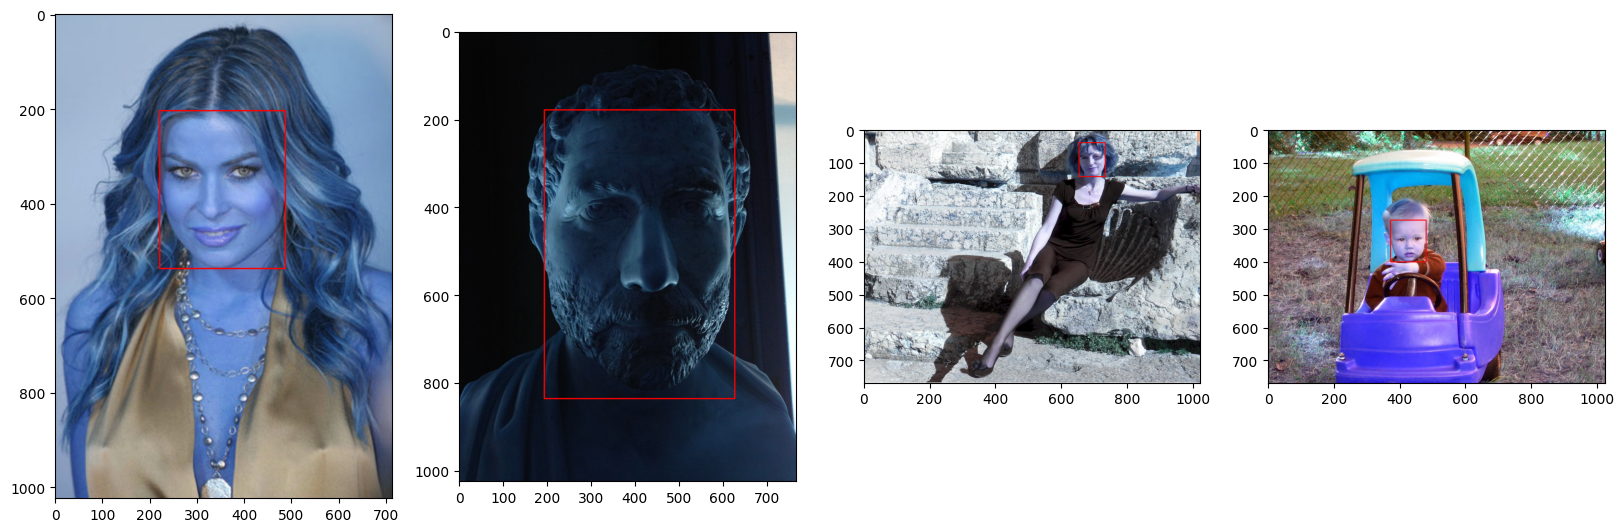

In [ ]:
visualize_batch(next(imgs_iter))